<h1>Signal Processing</h1>

I'm a cellular electrophysiologist, which simply means I'm a weird mix between an electrical engineer and a biochemist. I apply various drugs to neurons to see how it changes their electrical activity. Depending on the type of experiment you are running, this data can be very easy to analyze (action potential frequency) or it can be significantly more challenging (burst detection). 

A few years ago I had a problem: neither I nor anyone in my lab knew how to properly analyze some data I had collected. So, I asked an old mentor for some advice on signal processing and dove head first into writing my first data analysis script.

Mind you, that first script (and all the subsequent updated versions, the newest of which I used to actually analyze all my data) was written in Matlab. I'm cleaning things up a little bit and rewriting that old script in python for practice.

In [1]:
# let's get this out of the way
%matplotlib inline
%pylab inline
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


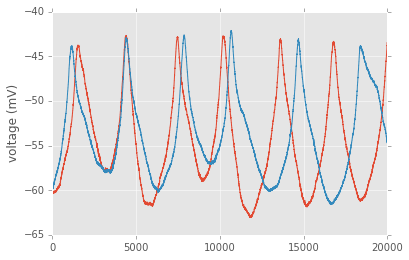

In [2]:
# load the data from a csv file and plot a little bit to get a feel for what we're looking at
from numpy import genfromtxt
SOP_data = genfromtxt('example_data/2015_02_25_0003_data.csv', delimiter=',')
plot(SOP_data[:20000,:2])
plt.ylabel('voltage (mV)')

So there it is. What we're looking at is what's called a slow oscillatory potential (SOP), and what I've plotted is the first two seconds of two "sweeps" of a five sweep recording. It's really one continuous recording, but the program breaks it into individual columns of data to make it easier to visualize and write experimental protocols. 

The experiment is as follows:

At 34s into each sweep I apply a drug and want to analyze how the signal changes.

Each sweep is 70s long and recorded with a sampling frequency of 10kHz.

Problem: I need to quantify the waveform, and taking the spectral density is the only logical way to do this when taking into account comparisions from across many different recordings. The problem is that the fft collapses the time domain, but in this case the time domain is critically important. What are we to do???
Solution: My solution was simple: just break the signal down and run lots of periodograms.

However, these are computation-heavy functions, so I wanted to be able to take advantage of NumPy and SciPy's speed. This also meant not using the notoriously slow 'for' loops. I had to figure out a quick way to break my signal down into the appropriately sized chunks before batch analyzing the whole shebang. 

Enter 'step_window.py'

In [3]:
# I'm leaving out the documentation for the time being. 
# The script with full documentation is in my 'playing_with_python'
# repository, and I'll add it in here later

def step_window(array, window, step):
    if array.ndim < 2:
        array = array.reshape(len(array), 1)
        columns = 1
    else:
        columns = array.shape[1]
    rows = array.shape[0]
    new_x, new_y = columns, window
    new_z = int(1 + ((rows - window) / step))
    new_array = np.empty([new_y, new_x, new_z])
    for x in range(new_z):
        new_array[:,:,x] = array[(0 + step * x):(window + step * x)]
    return new_array

In [4]:
# My PI and I decided upon a ~3.27s transform length that moved 1s
SOP_epochs = step_window(SOP_data, 2**15, 10**4)
print(SOP_epochs.shape)

(32768, 5, 67)


In [5]:
# Now I just need to run a periodogram on each column of data (and
# keep said data in the proper shaped array)
fs = 10**4
SOP_f, SOP_den = sp.signal.periodogram(SOP_epochs.T, fs)
SOP_den = SOP_den.T
print(SOP_den.shape)

(16385, 5, 67)


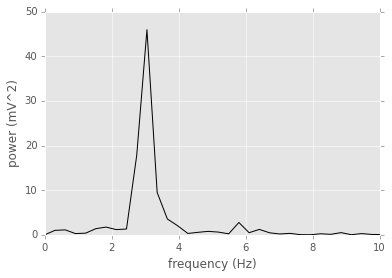

In [6]:
# An example trace. I'm only plotting out to 10Hz since that's the 
# biologically relevent range for these experiments
plot(SOP_f, SOP_den[:,0,0], color='black')
plt.axis([0,10,0,50])
plt.xlabel('frequency (Hz)')
plt.ylabel('power (mV^2)')

In [7]:
# Now I just need to take the sum of the power from 0-~10Hz for each
# (note: based on the transform length, the resolution is ~0.305Hz)
variance = SOP_den[0:33,:,:]
variance = np.sum(variance,axis=0)

In [8]:
# check if everything is up to snuff. looks like it is.
variance.T.shape

(67, 5)

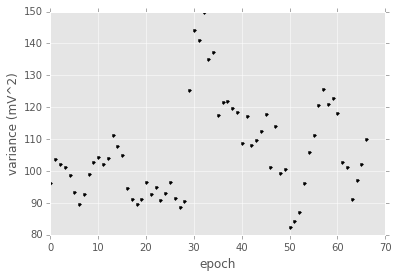

In [9]:
# a quick plot to visualize the first sweep.
plt.plot(variance.T[:,0], marker='.', color='black', linestyle='None')
plt.xlabel('epoch')
plt.ylabel('variance (mV^2)')

Now just to analyze the rest of my cells, pretty up the figures, and write the paper.